In [10]:
!pip install pandas
!pip install matplotlib
!pip install numpy

  Using cached matplotlib-3.10.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.0-cp313-cp313-macosx_11_0_arm64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.5 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached pillow-11.1.0-cp313-cp313-macosx_11_0_arm64.whl (3.1 MB)
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Generate Baseline Revenue

In [44]:
def generate_baseline(start_date, end_date, baseline_value, growth_rate=0, slope_changes=None, noise_std=0, preflight_days=0):
    """
    Generate a time series with revenue values including an optional preflight period
    
    Args:
        start_date (str or datetime): Start date of the time series
        end_date (str or datetime): End date of the time series  
        baseline_value (float): Initial value to use for revenue
        growth_rate (float, optional): Daily linear growth amount. Defaults to 0.
        slope_changes (dict, optional): Dictionary of dates and slope changes.
        noise_std (float, optional): Standard deviation of Gaussian noise to add. Defaults to 0.
        preflight_days (int, optional): Number of days to add before start_date. Defaults to 0.
    
    Returns:
        pd.DataFrame: DataFrame containing dates and revenue values
    """
    # Convert string dates to datetime if needed
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    if isinstance(end_date, str):
        end_date = pd.to_datetime(end_date)
    
    # Add preflight period if specified
    if preflight_days > 0:
        start_date = start_date - pd.Timedelta(days=preflight_days)
    
    # Create date range
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Initialize revenue list with growth
    revenue = []
    current_value = baseline_value
    current_slope = growth_rate
    
    # Convert slope change dates to datetime if provided
    slope_change_dates = {}
    if slope_changes:
        slope_change_dates = {pd.to_datetime(date): change for date, change in slope_changes.items()}
    
    # Generate revenue values for each date
    for date in date_range:
        # Apply any slope changes
        if slope_changes and date in slope_change_dates:
            current_slope += slope_change_dates[date]
        
        # Add noise if specified
        noisy_value = current_value
        if noise_std > 0:
            noisy_value += np.random.normal(0, noise_std)
            
        revenue.append(noisy_value)
        
        # Apply linear growth
        current_value += current_slope
    
    # Create DataFrame
    mmm_df = pd.DataFrame({
        'date': date_range,
        'revenue': revenue
    })
    
    return mmm_df


In [45]:
def calculate_total_baseline_revenue(df):
    """
    Calculate the total baseline revenue by summing all revenue values
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the baseline revenue data with 'revenue' column
        
    Returns:
    --------
    float
        Total baseline revenue
    """
    total = df['revenue'].sum()
    return total

# Calculate and display total baseline revenue
total_baseline = calculate_total_baseline_revenue(df)
print(f"Total Baseline Revenue: ${total_baseline:,.2f}")



Total Baseline Revenue: $38,659.62


# Generate Media Channels

In [56]:
def hill_cpm(spend, params):
    """Calculate CPM using Hill function with given parameters"""
    hill_factor = (spend ** params['hill_coefficient']) / \
                 (params['saturation_spend'] ** params['hill_coefficient'] + spend ** params['hill_coefficient'])
    return params['base_cpm'] * (1 + hill_factor)

def calculate_adstock(values, half_life):
    """Calculate adstock values using exponential decay"""
    decay_rate = np.log(2) / half_life
    weights = np.exp(-decay_rate * np.arange(len(values)))
    weights = weights / weights.sum()  # Normalize weights
    return np.convolve(values, weights, mode='full')[:len(values)]

def generate_channel_spend(date_range, base_spend, noise_level):
    """Generate daily spend with noise for a channel"""
    spend = np.zeros(len(date_range))
    spend[:] = base_spend
    noise = np.random.normal(0, noise_level * base_spend, len(date_range))
    spend += noise
    return np.maximum(spend, 0)  # Ensure no negative spend

def calculate_channel_metrics(spend, curve_params):
    """Calculate CPM, impressions and revenue for given spend and parameters"""
    cpm = hill_cpm(spend, curve_params)
    impressions = (spend * 1000) / cpm
    revenue = impressions * curve_params['conversion_rate']
    return cpm, impressions, revenue

def process_channel_periods(media_df, spend, curve_params, end_dt):
    """Process different time periods for a channel with changing parameters"""
    cpm = np.zeros(len(media_df))
    impressions = np.zeros(len(media_df))
    revenue = np.zeros(len(media_df))
    
    for i, current_params in enumerate(curve_params):
        current_start = pd.to_datetime(current_params['start_date'])
        current_end = pd.to_datetime(curve_params[i + 1]['start_date']) if i < len(curve_params) - 1 else end_dt
        
        # Define period mask
        if i == 0:
            mask = (media_df['date'] < current_end)
        else:
            mask = (media_df['date'] >= current_start) & (media_df['date'] < current_end)
        
        # Calculate metrics for period
        period_cpm, period_impressions, period_revenue = calculate_channel_metrics(
            spend[mask], current_params
        )
        
        # Assign values
        cpm[mask] = period_cpm
        impressions[mask] = period_impressions
        revenue[mask] = period_revenue
        
    return cpm, impressions, revenue

def generate_media_channels(start_date, end_date, channels_config, preflight_days=30):
    """
    Generate media spend, impression and revenue data with preflight period
    
    Parameters:
    -----------
    start_date : str
        Start date in 'YYYY-MM-DD' format (actual campaign start)
    end_date : str
        End date in 'YYYY-MM-DD' format
    channels_config : list of dict
        List of channel configurations
    preflight_days : int, optional
        Number of days to simulate before start_date for adstock effects. Defaults to 30.
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with date, spend, impressions, and revenue for each channel
    """
    # Convert dates and create date range
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    preflight_start = start_dt - pd.Timedelta(days=preflight_days)
    date_range = pd.date_range(start=preflight_start, end=end_dt, freq='D')
    
    # Initialize DataFrame
    media_df = pd.DataFrame({'date': date_range})
    
    for channel in channels_config:
        # Sort curve parameters by start date
        channel['curve_params'] = sorted(
            channel['curve_params'], 
            key=lambda x: pd.to_datetime(x['start_date'])
        )
        
        # Generate spend
        spend = generate_channel_spend(
            date_range, 
            channel['base_spend'], 
            channel['noise_level']
        )
        
        # Calculate metrics
        cpm, impressions, revenue = process_channel_periods(
            media_df, 
            spend, 
            channel['curve_params'], 
            end_dt
        )
        
        # Apply adstock effect
        revenue_with_adstock = calculate_adstock(revenue, channel['half_life'])
        
        # Add to DataFrame
        name = channel['name']
        media_df[f'{name}_spend'] = spend
        media_df[f'{name}_impressions'] = impressions
        media_df[f'{name}_cpm'] = cpm
        media_df[f'{name}_revenue'] = revenue_with_adstock
    
    # Add preflight flag
    media_df['is_preflight'] = media_df['date'] < start_dt
    
    return media_df

In [57]:
def generate_combined_data(
    start_date,
    end_date,
    baseline_value,
    channels_config,
    growth_rate=0,
    slope_changes=None,
    noise_std=0,
    preflight_days=30
):
    """
    Generate combined baseline and media channel data
    
    Parameters:
    -----------
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    baseline_value : float
        Initial baseline revenue value
    channels_config : list of dict
        Media channel configurations
    growth_rate : float, optional
        Daily baseline growth rate
    slope_changes : dict, optional
        Dictionary of dates and slope changes
    noise_std : float, optional
        Standard deviation for noise
    preflight_days : int, optional
        Number of preflight days. Defaults to 30.
    
    Returns:
    --------
    pandas.DataFrame
        Combined DataFrame with baseline and media data
    """
    # Generate baseline including preflight period
    baseline_df = generate_baseline(
        start_date,
        end_date,
        baseline_value,
        growth_rate=growth_rate,
        slope_changes=slope_changes,
        noise_std=noise_std,
        preflight_days=preflight_days
    )
    
    # Generate media data
    media_df = generate_media_channels(
        start_date,
        end_date,
        channels_config,
        preflight_days=preflight_days
    )
    
    # Merge baseline and media data
    combined_df = baseline_df.merge(media_df, on='date', how='left')
    
    # Calculate total revenue (baseline + media)
    media_cols = [col for col in combined_df.columns if col.endswith('_revenue')]
    combined_df['total_revenue'] = combined_df['revenue']  # baseline revenue
    for col in media_cols:
        combined_df['total_revenue'] += combined_df[col]
    
    return combined_df

# Add Promotional Vars

In [60]:
def _calculate_promo_revenue(baseline_revenue, lift_percentage, noise_level):
    """Calculate promotional revenue with noise for a given baseline revenue"""
    # Generate random noise factors between (1-noise_level) and (1+noise_level)
    noise = np.random.uniform(1 - noise_level, 1 + noise_level, size=len(baseline_revenue))
    
    # Calculate and return promo revenue with noise
    return baseline_revenue * (1 + lift_percentage) * noise

def _apply_single_promo_period(df, promo_name, start_date, end_date, lift, noise_level, revenue_cols):
    """Apply promotional effects for a single promotion period"""
    # Create mask for promo period
    promo_mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    
    # Update indicator columns
    df.loc[promo_mask, promo_name] = 1
    df.loc[promo_mask, 'promo'] = 1
    
    promo_rev_col = f'{promo_name}_revenue'
    
    # Apply lift to each revenue column
    for col in revenue_cols:
        baseline_revenue = df.loc[promo_mask, col]
        promo_revenue = _calculate_promo_revenue(baseline_revenue, lift, noise_level)
        
        # Calculate and store incremental revenue
        incremental = promo_revenue - baseline_revenue
        df.loc[promo_mask, promo_rev_col] += incremental
        
        # Update the revenue column
        df.loc[promo_mask, col] = promo_revenue
        
    return df

def _initialize_promo_columns(df, promo_name):
    """Initialize indicator and revenue columns for a promotion"""
    df[promo_name] = 0  # Indicator column
    df[f'{promo_name}_revenue'] = 0  # Incremental revenue column
    return df

def add_promos(df, promos, noise_level=0.2):
    """
    Add promotional effects to the revenue data with random noise, indicator columns,
    and incremental revenue columns
    
    Args:
        df: DataFrame containing revenue data
        promos: List of dictionaries with promo details like:
            [
                {
                    'name': 'amazon_day',
                    'dates': [
                        {
                            'start_date': '2024-01-05',
                            'end_date': '2024-01-07',
                            'lift_percentage': 0.2  # 20% increase
                        },
                        {
                            'start_date': '2024-07-05', 
                            'end_date': '2024-07-07',
                            'lift_percentage': 0.2
                        }
                    ]
                }
            ]
        noise_level: Float between 0-1 indicating how much random variation to add
    Returns:
        DataFrame with promotional effects, indicator columns and incremental revenue
    """
    # Create a copy to avoid modifying original
    df_with_promos = df.copy()
    
    # Get list of revenue columns
    revenue_cols = [col for col in df.columns if col.endswith('_revenue')]
    
    # Add overall promo indicator column
    df_with_promos['promo'] = 0
    
    # Apply each promo
    for promo in promos:
        promo_name = promo['name']
        
        # Initialize columns for this promo
        df_with_promos = _initialize_promo_columns(df_with_promos, promo_name)
        
        # Process each date range for this promo
        for date_range in promo['dates']:
            start = pd.to_datetime(date_range['start_date'])
            end = pd.to_datetime(date_range['end_date'])
            lift = date_range['lift_percentage']
            
            df_with_promos = _apply_single_promo_period(
                df_with_promos,
                promo_name,
                start,
                end,
                lift,
                noise_level,
                revenue_cols
            )
    
    return df_with_promos




# Add Context Vars

In [81]:
def add_activity_data(df, activities, noise_level=0.1):
    """
    Add activity time series data (like searches, email opens etc) with linear growth and conversion to revenue
    
    Args:
        df: DataFrame with date index
        activities: List of dicts with activity parameters like:
            [
                {
                    'name': 'searches',  # Name of activity
                    'start_value': 1000, # Starting daily value
                    'growth_rate': 0.02, # Daily linear growth rate
                    'conv_rate': 0.05    # Conversion rate to revenue (revenue per activity)
                },
                ...
            ]
        noise_level: Float between 0-1 indicating random variation
        
    Returns:
        DataFrame with new activity and revenue columns
    """
    df_with_activities = df.copy()
    
    # Calculate number of days from start
    start_date = df.index.min()
    days = (df.index - start_date).days
    
    for activity in activities:
        name = activity['name']
        start_val = activity['start_value']
        growth = activity['growth_rate']
        conv_rate = activity['conv_rate']
        
        # Calculate base activity values with linear growth
        base_activity = start_val + (days * growth * start_val)
        
        # Add random noise
        noise = np.random.normal(1, noise_level, len(df))
        activity_values = base_activity * noise
        
        # Calculate revenue
        revenue = activity_values * conv_rate
        
        # Add to dataframe
        df_with_activities[name] = activity_values
        df_with_activities[f'{name}_revenue'] = revenue
        
    return df_with_activities


In [64]:
# Example usage:
promos = [
    {
        'name': 'amazon_day',
        'dates': [
            {
                'start_date': '2024-01-05',
                'end_date': '2024-01-07',
                'lift_percentage': 0.2
            },
            {
                'start_date': '2024-01-20',
                'end_date': '2024-01-22', 
                'lift_percentage': 0.2
            }
        ]
    },
    {
        'name': 'holiday_sale',
        'dates': [
            {
                'start_date': '2024-01-15',
                'end_date': '2024-01-17',
                'lift_percentage': 0.3  # 30% increase
            }
        ]
    },
    {
        'name': 'flash_sale',
        'dates': [
            {
                'start_date': '2024-01-25',
                'end_date': '2024-01-26',
                'lift_percentage': 0.4  # 40% increase for short period
            }
        ]
    }
]

combined_df = add_promos(combined_df, promos, noise_level=0.1)

/var/folders/q5/fqrty7td6kl2szjpqjp9v56r0000gn/T/ipykernel_48150/2655992683.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[328.58336662 358.23293518 166.68433587]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[promo_mask, promo_rev_col] += incremental
/var/folders/q5/fqrty7td6kl2szjpqjp9v56r0000gn/T/ipykernel_48150/2655992683.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[846.78595872 905.5686975  713.99998293]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[promo_mask, promo_rev_col] += incremental
/var/folders/q5/fqrty7td6kl2szjpqjp9v56r0000gn/T/ipykernel_48150/2655992683.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[729

# Seasonality


In [78]:
def add_seasonality(df, baseline_col='revenue', seasonality_col='seasonality_revenue', 
                   annual_factor=0.15, semiannual_factor=0.08, quarterly_factor=0.05):
    """
    Add seasonality effects to the revenue that are smoothed and year-neutral
    
    Args:
        df: DataFrame with date index/column
        baseline_col: Column name containing baseline revenue
        seasonality_col: Name for new seasonality revenue column
        annual_factor: Amplitude of annual seasonality (default 0.15)
        semiannual_factor: Amplitude of semi-annual seasonality (default 0.08) 
        quarterly_factor: Amplitude of quarterly seasonality (default 0.05)
    
    Returns:
        DataFrame with added seasonality effects
    """
    # Convert date to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Create smooth seasonality pattern using sine waves
    # Combine multiple frequencies for more natural pattern
    days = (df['date'] - df['date'].min()).dt.days
    annual = np.sin(2 * np.pi * days / 365) * annual_factor  # Annual cycle
    semiannual = np.sin(4 * np.pi * days / 365) * semiannual_factor  # Semi-annual cycle
    quarterly = np.sin(8 * np.pi * days / 365) * quarterly_factor  # Quarterly cycle
    
    # Combine waves and ensure year-neutral by subtracting mean
    seasonality = annual + semiannual + quarterly
    seasonality = seasonality - seasonality.mean()
    
    # Calculate revenue impact
    df[seasonality_col] = df[baseline_col] * seasonality
    
    # Add to baseline
    df[baseline_col] = df[baseline_col] + df[seasonality_col]
    
    return df

# Apply seasonality to the combined dataframe
combined_df = add_seasonality(combined_df)


# Run the simulation

/var/folders/q5/fqrty7td6kl2szjpqjp9v56r0000gn/T/ipykernel_48150/2655992683.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1272.66133138  813.51299839 1644.56216736 2484.36207256 1730.21179202
  513.14802137 1984.59140659]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[promo_mask, promo_rev_col] += incremental
/var/folders/q5/fqrty7td6kl2szjpqjp9v56r0000gn/T/ipykernel_48150/2655992683.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  271.18916757  1067.9648411   1954.43471749  1007.68971909
  -606.0356245    256.19353326  -317.15375391 -1033.21370914
   451.69579221  -997.00679813  1674.89451464  2033.65585687
   852.88419481   896.56443474]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[promo_mask, promo_rev_co

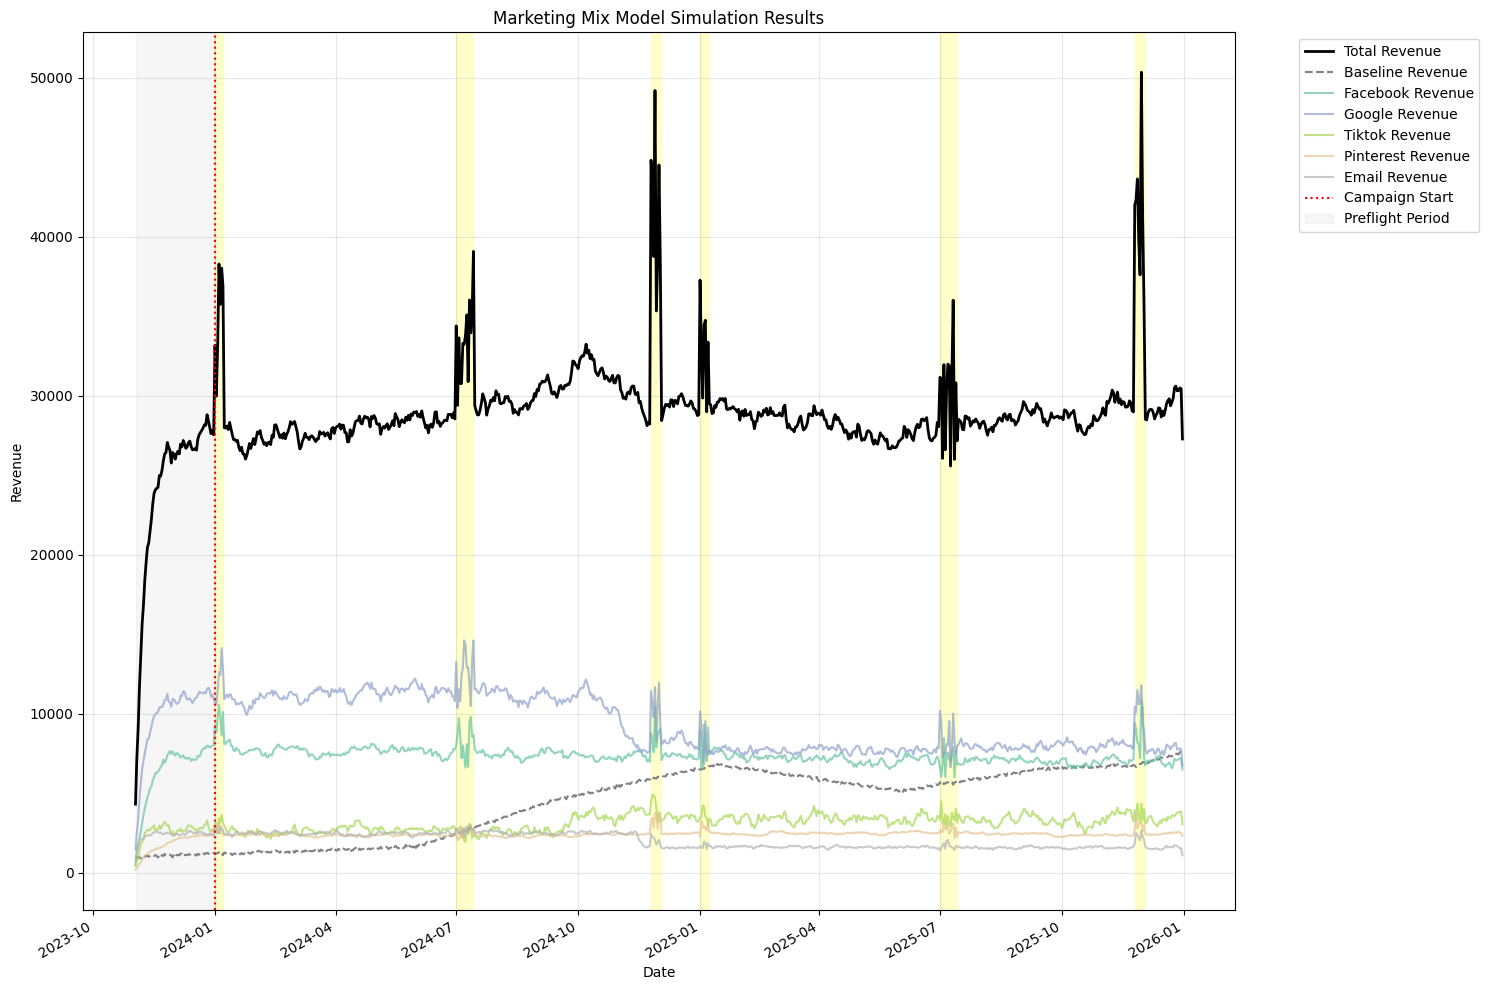


Simulation Summary Statistics:
Total Revenue: $22,833,022.96
Baseline Revenue: $3,477,056.16

Channel Performance:

Facebook:
  Spend: $728,273.87
  Revenue: $5,395,232.86
  ROI: 7.41

Google:
  Spend: $1,095,385.09
  Revenue: $6,833,627.87
  ROI: 6.24

Tiktok:
  Spend: $579,024.79
  Revenue: $2,302,475.41
  ROI: 3.98

Pinterest:
  Spend: $363,313.34
  Revenue: $1,782,572.20
  ROI: 4.91

Email:
  Spend: $219,350.42
  Revenue: $1,463,823.44
  ROI: 6.67


(          date      revenue  facebook_spend  facebook_impressions  \
 0   2023-11-02  1029.681448      656.942284          67968.510492   
 1   2023-11-03   930.960950     1297.930942         118155.189371   
 2   2023-11-04   983.847244      651.896717          67531.501501   
 3   2023-11-05   970.382329      773.715944          77845.707056   
 4   2023-11-06   905.835303      864.339260          85232.397728   
 ..         ...          ...             ...                   ...   
 786 2025-12-27  7490.054980      979.892450          78026.296281   
 787 2025-12-28  7440.777850     1061.653069          84146.907132   
 788 2025-12-29  7572.540013     1105.168539          87379.361000   
 789 2025-12-30  7637.789530      958.678367          76428.100722   
 790 2025-12-31  7568.018604      923.255104              0.000000   
 
      facebook_cpm  facebook_revenue  google_spend  google_impressions  \
 0        9.665392        512.625769   1489.769668       138662.783479   
 1       1

In [99]:
def run_simulation(
    start_date,
    end_date,
    baseline_params,
    channels_config,
    promo_config,
    preflight_days=30
):
    """
    Run a complete marketing mix simulation including baseline, media channels, and promotions
    
    Parameters:
    -----------
    start_date : str
        Start date of the campaign in 'YYYY-MM-DD' format
    end_date : str
        End date of the campaign in 'YYYY-MM-DD' format
    baseline_params : dict
        Parameters for baseline revenue generation
    channels_config : list of dict
        Media channel configurations
    promo_config : list of dict
        Promotional events configuration
    preflight_days : int, optional
        Number of days for preflight period. Defaults to 30.
        
    Returns:
    --------
    pandas.DataFrame
        Complete simulation results
    dict
        Summary statistics
    """
    # 1. Generate baseline with preflight
    baseline_df = generate_baseline(
        start_date=start_date,
        end_date=end_date,
        baseline_value=baseline_params['baseline_value'],
        growth_rate=baseline_params.get('growth_rate', 0),
        slope_changes=baseline_params.get('slope_changes', None),
        noise_std=baseline_params.get('noise_std', 0),
        preflight_days=preflight_days
    )
    
    # 2. Generate media channels data
    media_df = generate_media_channels(
        start_date=start_date,
        end_date=end_date,
        channels_config=channels_config,
        preflight_days=preflight_days
    )
    
    # 3. Merge baseline and media data
    df = baseline_df.merge(media_df, on='date', how='left')
    
    # 4. Add promotional effects if any
    if promo_config:
        df = add_promos(df, promo_config)  # Using the existing add_promos function
    
    # 5. Calculate total revenue
    df['total_revenue'] = df['revenue']  # Start with baseline
    
    # Add media revenue
    media_cols = [col for col in df.columns if col.endswith('_revenue') 
                 and col != 'total_revenue' and col != 'revenue']
    for col in media_cols:
        df['total_revenue'] += df[col]
    
    # 6. Calculate summary statistics
    stats = calculate_summary_stats(df, start_date, end_date, channels_config)
    
    return df, stats

def calculate_summary_stats(df, start_date, end_date, channels_config):
    """Calculate summary statistics for the simulation"""
    campaign_mask = (df['date'] >= pd.to_datetime(start_date))
    preflight_mask = ~campaign_mask
    
    stats = {
        'total_period': {
            'baseline_revenue': df['revenue'].sum(),
            'total_revenue': df['total_revenue'].sum(),
            'start_date': df['date'].min(),
            'end_date': df['date'].max()
        },
        'campaign_period': {
            'baseline_revenue': df.loc[campaign_mask, 'revenue'].sum(),
            'total_revenue': df.loc[campaign_mask, 'total_revenue'].sum(),
            'channels': {}
        },
        'preflight_period': {
            'baseline_revenue': df.loc[preflight_mask, 'revenue'].sum(),
            'total_revenue': df.loc[preflight_mask, 'total_revenue'].sum(),
            'channels': {}
        }
    }
    
    # Channel specific stats
    for channel in channels_config:
        name = channel['name']
        spend_col = f'{name}_spend'
        rev_col = f'{name}_revenue'
        
        # Campaign period stats
        campaign_spend = df.loc[campaign_mask, spend_col].sum()
        campaign_rev = df.loc[campaign_mask, rev_col].sum()
        
        stats['campaign_period']['channels'][name] = {
            'spend': campaign_spend,
            'revenue': campaign_rev,
            'roi': (campaign_rev / campaign_spend if campaign_spend > 0 else 0)
        }
        
        # Preflight period stats
        preflight_spend = df.loc[preflight_mask, spend_col].sum()
        preflight_rev = df.loc[preflight_mask, rev_col].sum()
        
        stats['preflight_period']['channels'][name] = {
            'spend': preflight_spend,
            'revenue': preflight_rev,
            'roi': (preflight_rev / preflight_spend if preflight_spend > 0 else 0)
        }
    
    return stats

# Sample parameters for running a complete simulation
sample_params = {
    'dates': {
        'start_date': '2024-01-01',
        'end_date': '2025-12-31',
        'preflight_days': 60
    },
    
    'baseline': {
        'baseline_value': 1000,  # Base daily revenue
        'growth_rate': 3,       # Daily growth
        'noise_std': 50,        # Random noise
        'slope_changes': {
            '2024-06-01': 25,   # Summer boost
            '2024-09-15': -10,  # Fall decline
            '2025-01-15': -30,  # Post-holiday drop
            '2025-06-01': 25,   # Summer boost
            '2025-09-15': -10,  # Fall decline
            '2025-11-25': 20    # Holiday season
        }
    },
    
    'channels': [
        {
            'name': 'facebook',
            'base_spend': 1000,
            'noise_level': 0.2,
            'half_life': 7,
            'curve_params': [
                {
                    'start_date': '2024-01-01',
                    'hill_coefficient': 1.2,
                    'base_cpm': 8,
                    'saturation_spend': 2000,
                    'conversion_rate': 0.08
                },
                {
                    'start_date': '2024-07-01',
                    'hill_coefficient': 1.5,
                    'base_cpm': 10,
                    'saturation_spend': 5000,
                    'conversion_rate': 0.08
                },
                {
                    'start_date': '2025-01-01',
                    'hill_coefficient': 1.3,
                    'base_cpm': 12,
                    'saturation_spend': 10000,
                    'conversion_rate': 0.09
                }
            ]
        },
        {
            'name': 'google',
            'base_spend': 1500,
            'noise_level': 0.15,
            'half_life': 5,
            'curve_params': [
                {
                    'start_date': '2024-01-01',
                    'hill_coefficient': 1.5,
                    'base_cpm': 10,
                    'saturation_spend': 8000,
                    'conversion_rate': 0.08
                },
                {
                    'start_date': '2024-11-01',
                    'hill_coefficient': 1.7,
                    'base_cpm': 15,
                    'saturation_spend': 15000,
                    'conversion_rate': 0.08
                }
            ]
        },
        {
            'name': 'tiktok',
            'base_spend': 800,
            'noise_level': 0.25,
            'half_life': 3,
            'curve_params': [
                {
                    'start_date': '2024-01-01',
                    'hill_coefficient': 1.4,
                    'base_cpm': 6,
                    'saturation_spend': 30000,
                    'conversion_rate': 0.02
                },
                {
                    'start_date': '2024-09-01',
                    'hill_coefficient': 1.6,
                    'base_cpm': 7,
                    'saturation_spend': 40000,
                    'conversion_rate': 0.03
                }
            ]
        },
        {
            'name': 'pinterest',
            'base_spend': 500,
            'noise_level': 0.18,
            'half_life': 10,
            'curve_params': [
                {
                    'start_date': '2024-01-01',
                    'hill_coefficient': 1.3,
                    'base_cpm': 5,
                    'saturation_spend': 5000,
                    'conversion_rate': 0.025
                },
                {
                    'start_date': '2024-10-01',
                    'hill_coefficient': 1.4,
                    'base_cpm': 6,
                    'saturation_spend': 8000,
                    'conversion_rate': 0.03
                }
            ]
        },
        {
            'name': 'email',
            'base_spend': 300,
            'noise_level': 0.1,
            'half_life': 2,
            'curve_params': [
                {
                    'start_date': '2024-01-01',
                    'hill_coefficient': 1.1,
                    'base_cpm': 2,
                    'saturation_spend': 1000,
                    'conversion_rate': 0.02
                },
                {
                    'start_date': '2024-11-15',
                    'hill_coefficient': 1.2,
                    'base_cpm': 2.5,
                    'saturation_spend': 1500,
                    'conversion_rate': 0.015
                }
            ]
        }
    ],
    
    'promotions': [
        {
            'name': 'new_year_sale',
            'dates': [
                {
                    'start_date': '2024-01-01',
                    'end_date': '2024-01-07',
                    'lift_percentage': 0.1
                },
                {
                    'start_date': '2025-01-01',
                    'end_date': '2025-01-07',
                    'lift_percentage': 0.1
                }
            ]
        },
        {
            'name': 'summer_sale',
            'dates': [
                {
                    'start_date': '2024-07-01',
                    'end_date': '2024-07-14',
                    'lift_percentage': 0.08
                },
                {
                    'start_date': '2025-07-01',
                    'end_date': '2025-07-14',
                    'lift_percentage': 0.08
                }
            ]
        },
        {
            'name': 'black_friday',
            'dates': [
                {
                    'start_date': '2024-11-25',
                    'end_date': '2024-12-02',
                    'lift_percentage': 0.3
                },
                {
                    'start_date': '2025-11-25',
                    'end_date': '2025-12-02',
                    'lift_percentage': 0.3
                }
            ]
        }
    ]
}

def run_sample_simulation():
    """Run a sample simulation with the predefined parameters"""
    params = sample_params
    
    # Run simulation
    results_df, stats = run_simulation(
        start_date=params['dates']['start_date'],
        end_date=params['dates']['end_date'],
        baseline_params=params['baseline'],
        channels_config=params['channels'],
        promo_config=params['promotions'],
        preflight_days=params['dates']['preflight_days']
    )
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    # Use a color map for better color selection
    channel_colors = plt.cm.Set2(np.linspace(0, 1, len(params['channels'])))
    
    # Plot total and baseline revenue
    plt.plot(results_df['date'], results_df['total_revenue'], 
             label='Total Revenue', linewidth=2, color='black')
    plt.plot(results_df['date'], results_df['revenue'], 
             label='Baseline Revenue', linestyle='--', color='gray')
    
    # Plot channel revenues
    for i, channel in enumerate(params['channels']):
        name = channel['name']
        plt.plot(results_df['date'], results_df[f'{name}_revenue'], 
                label=f'{name.title()} Revenue', 
                color=channel_colors[i], 
                alpha=0.7)
    
    # Add vertical line for campaign start
    campaign_start = pd.to_datetime(params['dates']['start_date'])
    plt.axvline(x=campaign_start, color='r', linestyle=':', label='Campaign Start')
    
    # Shade the preflight period
    plt.axvspan(results_df['date'].min(), campaign_start, 
                alpha=0.2, color='lightgray', label='Preflight Period')
    
    # Mark promotional periods
    if params.get('promotions'):
        for promo in params['promotions']:
            for period in promo['dates']:
                start = pd.to_datetime(period['start_date'])
                end = pd.to_datetime(period['end_date'])
                plt.axvspan(start, end, alpha=0.2, color='yellow')
                # plt.text(start, plt.ylim()[1], f" {promo['name']}", rotation=90)
    
    plt.title('Marketing Mix Model Simulation Results')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.grid(True, alpha=0.3)
    
    # Improve legend placement and formatting
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
    
    # Improve date formatting on x-axis
    plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
    
    # Add some padding to the layout
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSimulation Summary Statistics:")
    print("=" * 50)
    print(f"Total Revenue: ${stats['total_period']['total_revenue']:,.2f}")
    print(f"Baseline Revenue: ${stats['total_period']['baseline_revenue']:,.2f}")
    print("\nChannel Performance:")
    for channel, metrics in stats['campaign_period']['channels'].items():
        print(f"\n{channel.title()}:")
        print(f"  Spend: ${metrics['spend']:,.2f}")
        print(f"  Revenue: ${metrics['revenue']:,.2f}")
        print(f"  ROI: {metrics['roi']:.2f}")
    
    return results_df, stats

run_sample_simulation()

# Plots to check

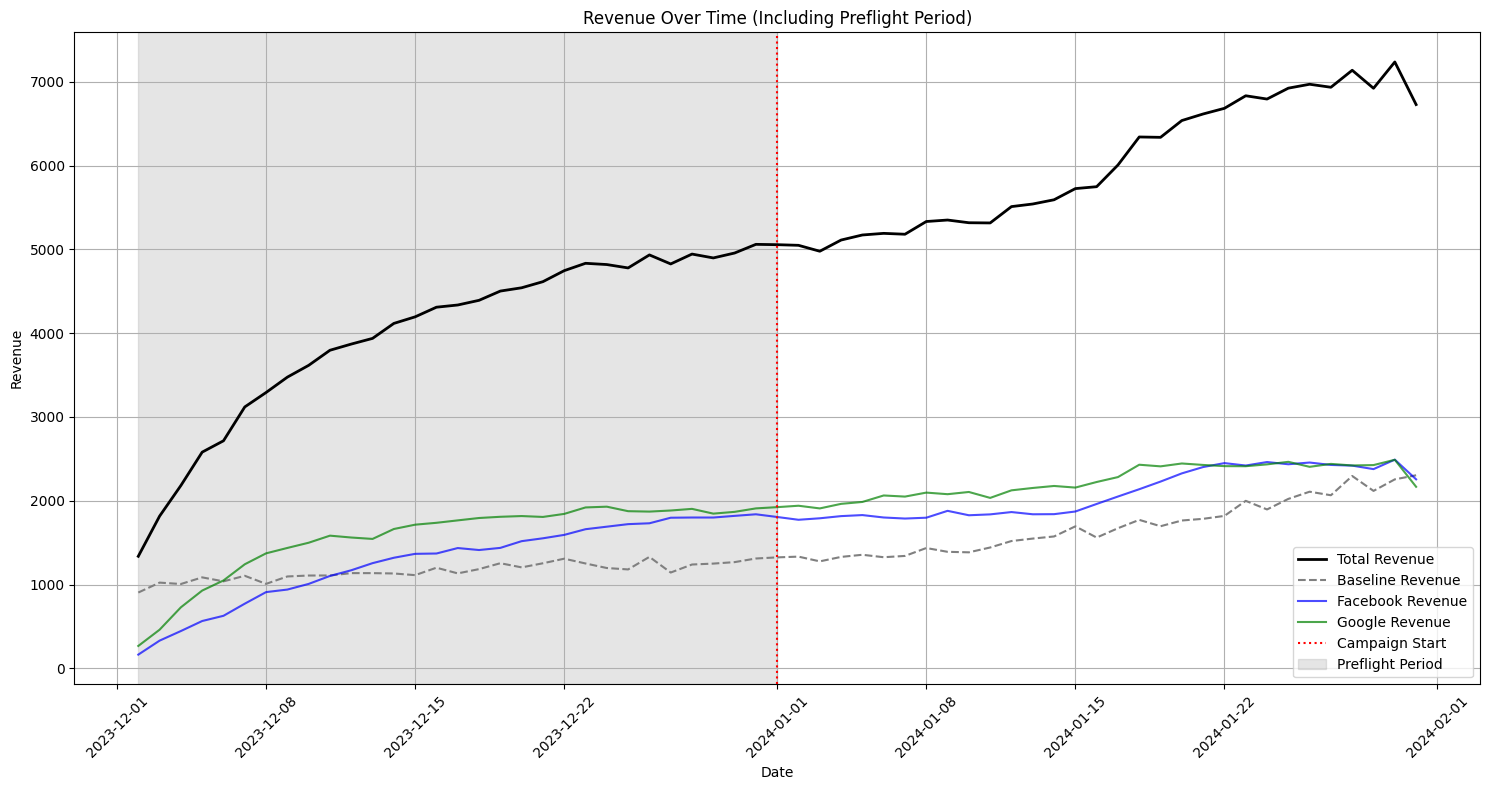


Preflight Period Statistics:
Preflight Start: 2023-12-02
Campaign Start: 2024-01-01
Preflight Days: 30

Facebook Channel:
Preflight Spend: $29,769.05
Preflight Revenue: $38,165.76

Google Channel:
Preflight Spend: $42,500.51
Preflight Revenue: $46,639.53


In [86]:
# Test the updated functions
start_date = '2024-01-01'
end_date = '2024-01-31'
preflight_days = 30

# Generate baseline with preflight
baseline_df = generate_baseline(
    start_date=start_date,
    end_date=end_date,
    baseline_value=1000,
    growth_rate=10,
    slope_changes={
        '2024-01-10': 30,
        '2024-01-20': 10
    },
    noise_std=50,
    preflight_days=preflight_days
)

# Generate media data with preflight
media_df = generate_media_channels(
    start_date=start_date,
    end_date=end_date,
    channels_config=channels_config,
    preflight_days=preflight_days
)

# Merge the data
combined_df = baseline_df.merge(media_df, on='date', how='left')

# Calculate total revenue
media_cols = [col for col in combined_df.columns if col.endswith('_revenue')]
combined_df['total_revenue'] = combined_df['revenue']  # baseline revenue
for col in media_cols:
    combined_df['total_revenue'] += combined_df[col]

# Plot the results
plt.figure(figsize=(15,8))

# Plot total and baseline revenue
plt.plot(combined_df['date'], combined_df['total_revenue'], 
         label='Total Revenue', linewidth=2, color='black')
plt.plot(combined_df['date'], combined_df['revenue'], 
         label='Baseline Revenue', linestyle='--', color='gray')

# Plot individual channel revenues
colors = ['blue', 'green']
for i, channel in enumerate(channels_config):
    channel_name = channel['name']
    plt.plot(combined_df['date'], combined_df[f'{channel_name}_revenue'], 
             label=f'{channel_name.title()} Revenue', 
             color=colors[i], alpha=0.7)

# Add vertical line for campaign start
campaign_start = pd.to_datetime(start_date)
plt.axvline(x=campaign_start, color='r', linestyle=':', label='Campaign Start')

# Shade the preflight period
plt.axvspan(combined_df['date'].min(), campaign_start, 
            alpha=0.2, color='gray', label='Preflight Period')

plt.title('Revenue Over Time (Including Preflight Period)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print some statistics
print("\nPreflight Period Statistics:")
preflight_mask = combined_df['is_preflight']
print(f"Preflight Start: {combined_df['date'].min().strftime('%Y-%m-%d')}")
print(f"Campaign Start: {campaign_start.strftime('%Y-%m-%d')}")
print(f"Preflight Days: {preflight_days}")

for channel in channels_config:
    channel_name = channel['name']
    preflight_spend = combined_df.loc[preflight_mask, f'{channel_name}_spend'].sum()
    preflight_revenue = combined_df.loc[preflight_mask, f'{channel_name}_revenue'].sum()
    print(f"\n{channel_name.title()} Channel:")
    print(f"Preflight Spend: ${preflight_spend:,.2f}")
    print(f"Preflight Revenue: ${preflight_revenue:,.2f}")

In [69]:
print(combined_df.to_string())

         date      revenue  facebook_spend  facebook_impressions  facebook_cpm  facebook_revenue  google_spend  google_impressions  google_cpm  google_revenue  is_preflight  total_revenue  promo  amazon_day  amazon_day_revenue  holiday_sale  holiday_sale_revenue  flash_sale  flash_sale_revenue
0  2023-12-02   989.373430     1370.756429         121809.382964     11.253291        230.222980   1018.302689        97590.894676   10.434403      189.536579          True    1409.132989      0           0            0.000000             0              0.000000           0            0.000000
1  2023-12-03  1043.481458     1134.760172         104145.217277     10.895941        405.355638   1785.157032       162974.777916   10.953579      481.523346          True    1930.360441      0           0            0.000000             0              0.000000           0            0.000000
2  2023-12-04  1057.099961     1084.250612         100278.866285     10.812354        556.669924   1869.061910     

In [37]:
channels_config = [
    {
        'name': 'facebook',
        'base_spend': 1000,
        'noise_level': 0.2,
        'half_life': 7,  # Adding half-life parameter
        'curve_params': [
            {
                'start_date': '2024-01-01',
                'hill_coefficient': 1,
                'base_cpm': 8,
                'saturation_spend': 2000,
                'conversion_rate': 0.02  # Adding conversion rate
            },
            {
                'start_date': '2024-01-15',
                'hill_coefficient': 1.5,
                'base_cpm': 8,
                'saturation_spend': 3000,
                'conversion_rate': 0.025  # Slightly higher conversion rate in second period
            }
        ]
    },
    {
        'name': 'google',
        'base_spend': 1500,
        'noise_level': 0.15,
        'half_life': 5,  # Adding half-life parameter
        'curve_params': [
            {
                'start_date': '2024-01-01',
                'hill_coefficient': 1.5,
                'base_cpm': 10,
                'saturation_spend': 8000,
                'conversion_rate': 0.015  # Adding conversion rate
            },
            {
                'start_date': '2024-01-10',
                'hill_coefficient': 2.5,
                'base_cpm': 10,
                'saturation_spend': 7000,
                'conversion_rate': 0.018  # Slightly higher conversion rate in second period
            }
        ]
    }
]

media_df = generate_media_channels(
    '2024-01-01',
    '2024-01-31',
    channels_config
)

In [ ]:
# Generate the data
df = generate_baseline(
    '2024-01-01', 
    '2024-01-31', 
    1000,
    growth_rate=0.001
    slope_changes={
        '2024-01-10': 30,
        '2024-01-20': 10
    },
    noise_std=50
)

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['revenue'], marker='o')
plt.title('Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()